In [1]:
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# surpress warnings
import warnings
warnings.filterwarnings('ignore')


# Question 3

In this question, we used the same helper methods we used in the previous questions.

In [44]:
def get_files(folder):
    directory = "data/%s/" % folder
    return glob.glob(directory + "*.json")

def load_dict(file):
    d = None
    with open(file.replace("\\", "/")) as file:
        d = json.load(file)
    return d

def load_df(folder):

    files = get_files(folder)
    get_date = lambda file_name: file_name[len(folder) + 6:-15]

    if folder in ["youtube_top100", "radio3fm_megahit", "radio538_alarmschijf"]:

        keys = ['viewCount',
                'likeCount',
                'dislikeCount',
                'commentCount',
                #'favoriteCount'
                ]
                
        df = []
        for year_file in files:
            year_data = load_dict(year_file)
            for song_data in year_data:
                row = [get_date(year_file), song_data['snippet']['title']]
                row.extend([song_data['statistics'][key] for key in keys])
                df.append(row)

        columns = ['date', 'songName']
        columns.extend(keys)
        df = pd.DataFrame(df, columns = columns)

        for column in set(df.columns).difference({'date', 'songName'}):
            df[column] = df[column].astype('double')

        df['likeDislikeDiff']  = df['likeCount'] - df['dislikeCount']
        df['likeDislikeTotal'] = df['likeCount'] + df['dislikeCount']

        df.index = pd.to_datetime(df['date'], format='%Y%m%d')
            
        return df
    if folder == "spotify_top100":        

        # missing artist name

        keys = ['name',
                'popularity']

        df = []
        for year_file in files:
            year_data = load_dict(year_file)
            for track_data in year_data['tracks']['items']:
                row = [get_date(year_file)]
                row.extend(track_data['track'][key] for key in keys)
                df.append(row)
        
        columns = ['date']
        columns.extend(keys)
        df = pd.DataFrame(df, columns = columns)
        
        df.index = pd.to_datetime(df['date'], format='%Y%m%d')
        df = df.rename(columns={'name':'songName'})

        return df
    else:
        raise AssertionError("Function not implemented for the folder \"%s\"" % folder)

def get_song_dfs(df, n=None, seed=37):
    """Get a list of dataframes. Each dataframe represents one song

    Create the dataframe with the song name and then interpolate to fill
    empty dates

    Args:
        df (DataFrame): Original dataframe. Should be created from Youtube format
        n (int): Number of song dfs to create and return. Default value in None,
            all the possible songs are used to create song dfs when n is None.
    """
    np.random.seed(seed)

    songs = df['songName'].unique()
    if n:
        songs = np.random.choice(songs, n)
    song_dfs = []
    for song_name in songs:
        song_df = df[df['songName'] == song_name]
        song_df = song_df.drop_duplicates(subset='date')
        song_df = song_df.resample('D').asfreq()
        song_df = song_df.interpolate()
        song_dfs.append(song_df)
    return song_dfs

get_line_method = lambda p: lambda x: p[0] * x + p[1]

def get_view_growth(viewCount):
    return (viewCount.shift(-1) - viewCount).dropna()

def get_z_hat_df(series):
    df = pd.DataFrame({'z':series, 'z_hat':series.shift(-1)})
    df = df.dropna()
    return df

def apply_p(p, series):
    l = len(p)
    sum = (series ** (l-1)) * p[0]
    for i in range(l-1):
        sum += (series ** (l-i-2)) * p [i+1]
    return sum

In [19]:
youtube_df = load_df("youtube_top100")
youtube_df

,date,songName,viewCount,likeCount,dislikeCount,commentCount,likeDislikeDiff,likeDislikeTotal
date,,,,,,,,
2015-11-09,20151109,Adele - Hello,297130779.0,4093202.0,101335.0,291458.0,3991867.0,4194537.0
2015-11-09,20151109,Justin Bieber - Sorry (Dance Video),92743480.0,1355977.0,71243.0,104720.0,1284734.0,1427220.0
2015-11-09,20151109,Drake - Hotline Bling,57075104.0,672355.0,60531.0,72120.0,611824.0,732886.0
2015-11-09,20151109,Justin Bieber - What Do You Mean?,276365510.0,2310400.0,254413.0,189319.0,2055987.0,2564813.0
2015-11-09,20151109,Shawn Mendes - Stitches (Official Video),72148555.0,906781.0,14618.0,57624.0,892163.0,921399.0
...,...,...,...,...,...,...,...,...
2016-11-28,20161128,Flo Rida - My House [Official Video],177568317.0,965907.0,37839.0,47163.0,928068.0,1003746.0
2016-11-28,20161128,Drake - Right Hand Girl dance vine,700870.0,7521.0,256.0,457.0,7265.0,7777.0
2016-11-28,20161128,Rihanna - Bitch Better Have My Money (Explicit),100217083.0,1590438.0,192198.0,128521.0,1398240.0,1782636.0


We loaded the Youtube dataset and plotted the number of views against songs. We observed that there is potentially a power-law relationship.

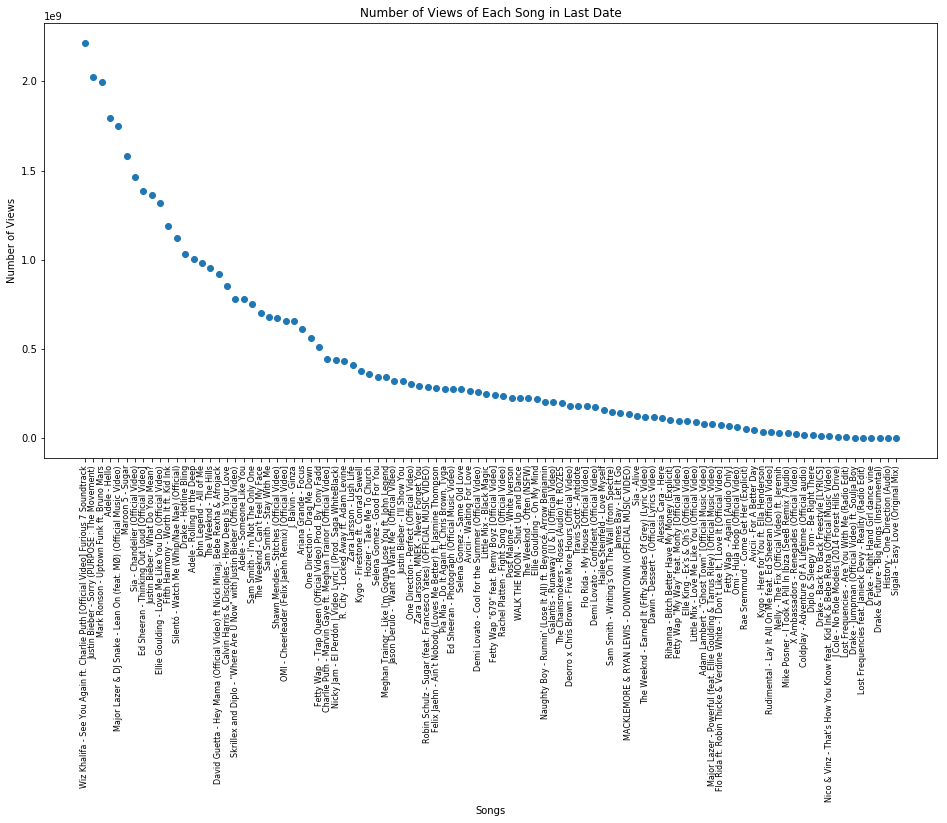

In [20]:
last_day_df = youtube_df[youtube_df['date'] == youtube_df['date'].max()]
last_day_df = last_day_df.sort_values(by='viewCount', ascending=False)

plt.figure(figsize=(16,8))
plt.scatter(range(last_day_df.shape[0]), 
            last_day_df['viewCount'],
            label="Data Points")
plt.xlabel("Songs")
plt.xticks(range(last_day_df.shape[0]),
           labels = last_day_df['songName'],
           rotation = 90,
           fontsize = 8)
plt.ylabel("Number of Views")

plt.title("Number of Views of Each Song in Last Date")
plt.show()

In [21]:
song_dfs = get_song_dfs(youtube_df, seed = 2)
songs_df = pd.concat(song_dfs)

Next, we randomly picked 4 dates from our dataset. 

For each date, we picked the rows that correspond to this date, found the distribution using np.histogram and plotted the distributions. Then we applied log function to both x and y coordinates of the distribution we generated and fitted a line to the resulting series. After we fitted a line, we drew this line and also plotted the distribution points with a log-log scale. In the end we have two plots for each date, both plotted in a single row of the subplots.

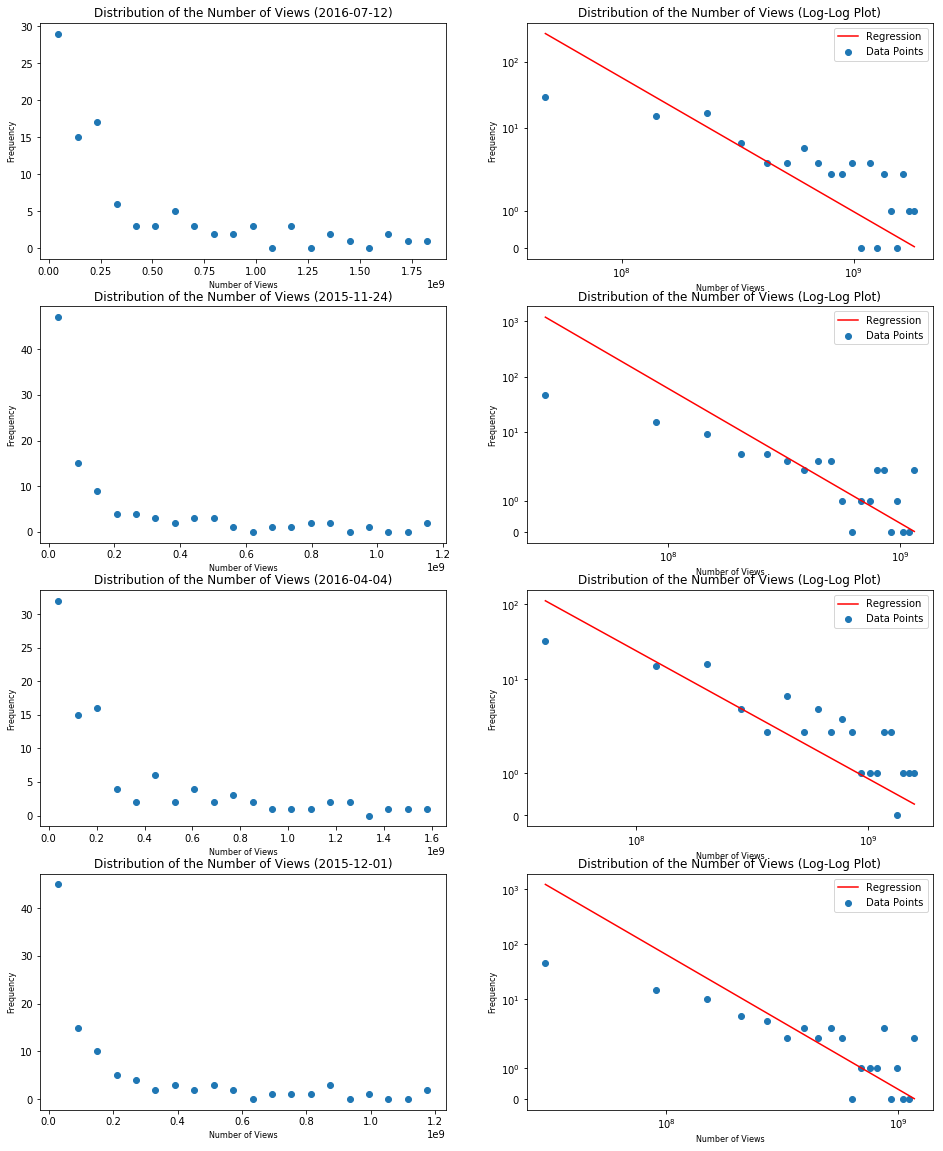

In [22]:
number_of_dates = 4
dates = np.random.choice(songs_df['date'].unique(), number_of_dates)
fig, axs = plt.subplots(number_of_dates,2, figsize=(16,20))

for i,date in enumerate(dates):

    # picking the rows with the date
    date_df = songs_df[songs_df['date'] == date]
    # finding distribution
    count, division = np.histogram(date_df['viewCount'], bins = 20)
    group_mean = (division + (division[1] - division[0])/2)[:-1]

    two_axs = axs[i,:]

    for ax in two_axs:
        ax.scatter(group_mean, count, label="Data Points")
        ax.set_xlabel("Number of Views", fontsize=8)
        ax.set_ylabel("Frequency", fontsize=8)

    # getting the log of x and y to fit a line
    x_logged, y_logged = [np.log(l+1e-6) for l in [group_mean, count]]

    # fitting a line through logged x and y
    p = np.polyfit(x_logged, y_logged, deg=1)
    line = get_line_method(p)
    interval = [f(x_logged) for f in [min, max]]
    prediction = [line(i) for i in interval]
    # plotting the fitted line
    two_axs[1].plot(np.exp(interval), np.exp(prediction), label="Regression", color='red')

    two_axs[0].set_title("Distribution of the Number of Views (%s)" % str(date_df.index[0])[:10])
    two_axs[1].set_title("Distribution of the Number of Views (Log-Log Plot)")

    two_axs[1].legend()

    two_axs[1].set_xscale("symlog")
    two_axs[1].set_yscale("symlog")

plt.show()

# Spotify

In [45]:
spotify_df = load_df("spotify_top100")
song_dfs = get_song_dfs(spotify_df, seed = 2)
songs_df = pd.concat(song_dfs)

In [46]:
songs_df

,date,songName,popularity
date,,,
2015-11-09,20151109,Hello,97.0
2015-11-10,20151110,Hello,98.0
2015-11-11,20151111,Hello,98.0
2015-11-12,20151112,Hello,98.0
2015-11-13,20151113,Hello,98.0
...,...,...,...
2016-11-27,20161127,Die For You,0.0
2016-11-28,20161128,Die For You,65.0
2016-11-26,20161126,Ordinary Life,0.0


We then applied the same approach to the Spotify dataset. 

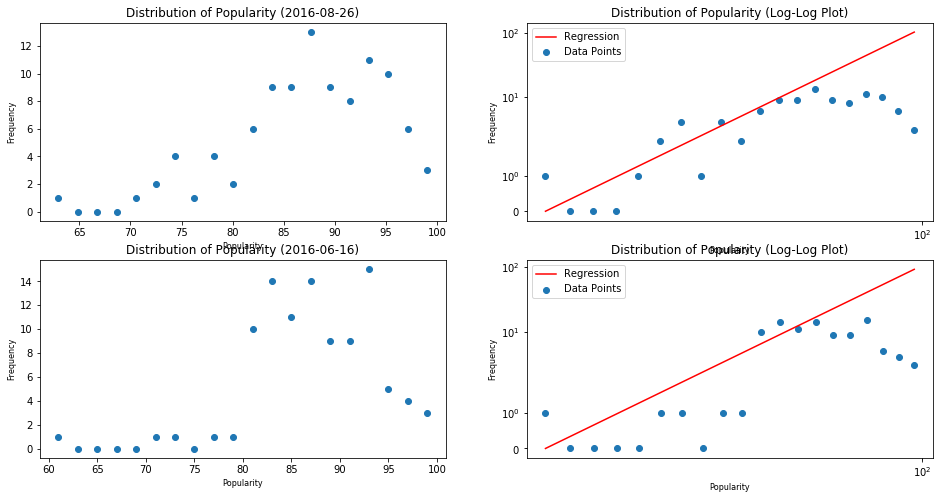

In [51]:
number_of_dates = 2
dates = np.random.choice(songs_df['date'].unique(), number_of_dates)
fig, axs = plt.subplots(number_of_dates,2, figsize=(16,8))

for i,date in enumerate(dates):

    # picking the rows with the date
    date_df = songs_df[songs_df['date'] == date]
    # finding distribution
    count, division = np.histogram(date_df['popularity'], bins = 20)
    group_mean = (division + (division[1] - division[0])/2)[:-1]

    two_axs = axs[i,:]

    for ax in two_axs:
        ax.scatter(group_mean, count, label="Data Points")
        ax.set_xlabel("Popularity", fontsize=8)
        ax.set_ylabel("Frequency", fontsize=8)

    # getting the log of x and y to fit a line
    x_logged, y_logged = [np.log(l+1e-6) for l in [group_mean, count]]

    # fitting a line through logged x and y
    p = np.polyfit(x_logged, y_logged, deg=1)
    line = get_line_method(p)
    interval = [f(x_logged) for f in [min, max]]
    prediction = [line(i) for i in interval]
    # plotting the fitted line
    two_axs[1].plot(np.exp(interval), np.exp(prediction), label="Regression", color='red')

    two_axs[0].set_title("Distribution of Popularity (%s)" % str(date_df.index[0])[:10])
    two_axs[1].set_title("Distribution of Popularity (Log-Log Plot)")

    two_axs[1].legend()

    two_axs[1].set_xscale("symlog")
    two_axs[1].set_yscale("symlog")

plt.show()